In [105]:
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, cross_val_score,cross_validate
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score,confusion_matrix,plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve

In [9]:
y_train = pd.read_csv('y_train_hds.csv')

In [21]:
X_train = pd.read_csv("X_train_hds.csv",encoding='cp949')

In [14]:
X_train = X_train.iloc[:,11:]

In [34]:
X_train = X_train.groupby('custid')['import_flg','tot_amt','dis_amt','net_amt','inst_mon','inst_fee'].mean().round(2)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [37]:
X_train.reset_index(inplace = True)

In [40]:
df = pd.merge(X_train,y_train,on='custid')

## 1) train_test_split

In [50]:
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,:-1],df[['gender']],test_size = 0.3,stratify = df['gender'])

In [52]:
y_train.value_counts(normalize = True)

gender
0         0.696048
1         0.303952
dtype: float64

In [53]:
y_test.value_counts(normalize = True)

gender
0         0.696111
1         0.303889
dtype: float64

- stratify를 통해 class 비율을 비슷하게 나누었다.
- shuffle을 이용하여 좀 더 효율적인 학습 및 테스트 데이터 세트를 만드는 데 사용

### HoldOut방식(train_test_split) 장단점

#### 단점
- train / test 셋이 어떻게 나눠 지느냐에 따라 결과가 달라진다.
    - 데이터가 충분히 많다면 변동성이 흡수되어 괜찮지만, 수천건 정도로 적을 때 문제가 발생할 수 있다.
    
- 데이터셋의 양이 적을 경우 학습을 위한 데이터 양이 너무 적어 학습이 제대로 안될 수 있다.

# 1. 교차검증

## 1) K-Fold 교차 검증

- 가장 보편적인 교차 검증 기법
- 훈련 세트의 분할에 덜 민감한 성능 추정을 얻을 수 있다.
- 그렇지만 원 데이터셋의 row 순서대로 분할하기에 불균형 문제가 발생할 수 있다.

In [59]:
kfold = KFold(n_splits=5,shuffle=True,random_state=123)

In [60]:
lgbm = LGBMClassifier(random_state=123)

In [70]:
cross_val_score(lgbm,X_train,y_train,cv=kfold,scoring='precision')

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0.48469388, 0.5078534 , 0.44864865, 0.52238806, 0.57541899])

- scoring : accuracy, f1, neg_log_loss,precision, recall, roc_auc

In [ ]:
rf = RandomForestClassifier(random_state = 123, n_jobs=-1, n_estimators=100)
rf_pred = np.zeros((test.shape[0]))

i = 0
for tr, val in kfold.split(train,y_over) :
    i += 1
    X_train,y_train = train.iloc[tr],y_over.iloc[tr]
    X_val,y_val = train.iloc[val],y_over.iloc[val]
    
    rf.fit(X_train,y_train)
    pred = rf.predict(X_val)
    
    print("KFold{}의 Accuracy : {}\n".format(i,accuracy_score(y_val,pred)))
    sub_pred = rf.predict_proba(test)[:,1] / 5
    rf_pred += sub_pred

## 2) StratifiedKFold

- 불균형한 분포도를 가진 레이블 데이터 집합을 위한 KFold 방식

In [72]:
skf = StratifiedKFold(n_splits=4,shuffle=True, random_state=123)

In [74]:
cross_val_score(lgbm,X_train,y_train,cv = skf, scoring='accuracy')

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0.69561905, 0.69314286, 0.69428571, 0.6992381 ])

In [77]:
cross_validate(lgbm,X_train,y_train,cv = skf)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'fit_time': array([0.16456056, 0.19248533, 0.16854906, 0.16954708]),
 'score_time': array([0.00997281, 0.0089767 , 0.00897646, 0.00897646]),
 'test_score': array([0.69561905, 0.69314286, 0.69428571, 0.6992381 ])}

# 2. 분류 평가지표

## 1) 정확도(Accuracy)

정확도(Accuracy) =  $\frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$

- 직관적으로 모델 예측 성능 평가 지표
- 이진분류의 경우 데이터 구성에 따라 ML 모델 성능 왜곡할 수 있다. -> 정확도 수치 하나만 가지고 성능 평가하기 어렵다.
- 불균형 데이터의 경우 정확한 평가지표가 될 수 없다.

In [79]:
lgbm.fit(X_train,y_train)

LGBMClassifier(random_state=123)

In [85]:
print("Accuracy : {}".format(accuracy_score(y_test,lgbm.predict(X_test))))

Accuracy : 0.696


## 2) Confusion Matrix

- 불균형한 데이터에서는 정확도만으로는 모델 신뢰도가 떨어질 수 있다.

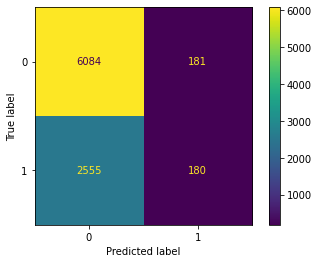

In [98]:
plot_confusion_matrix(lgbm,X_test,y_test)

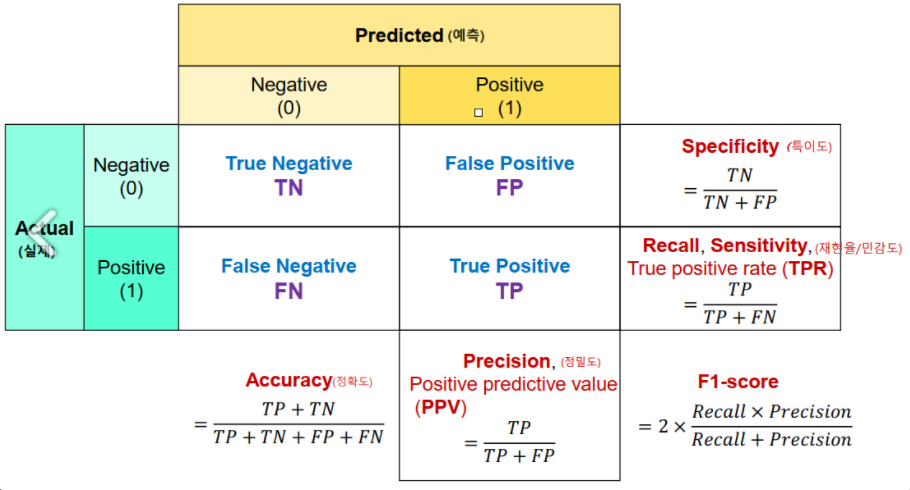

In [86]:
confusion_matrix(y_test,lgbm.predict(X_test))

array([[6084,  181],
       [2555,  180]], dtype=int64)

## 3) 정밀도와 재현율

#### 정밀도 : $\frac{TP}{(FP + TP)}$

- Positive로 예측한 것 중 예측과 실제 값이 Positive인 것의 비율

#### 재현율 : $\frac{TP}{(FN + TP)}$

- 실제 값이 Positive인 것 중에 예측과 실제 값이 Positive인 것의 비율
- 민감도, TPR로 불린다

### 정밀도가 중요 지표인 경우
- 예시 : 스팸메일 여부
- 실제 Negative 데이터를 Positive로 잘못 판단하면 업무상 큰 영향이 있는 경우
- FP를 낮추는데 초점

### 재현율이 중요 지표인 경우
- 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향
- 예를 들면 암 판단 모델, 보험사기와 같은 금융 사기 적발 모델

In [91]:
print("정밀도 :",precision_score(y_test,lgbm.predict(X_test)))
print("재현율 :",recall_score(y_test,lgbm.predict(X_test)))

정밀도 : 0.4986149584487535
재현율 : 0.06581352833638025


In [94]:
lgbm.predict_proba(X_test)[:,1]

array([0.49861817, 0.26994048, 0.28833196, ..., 0.30524051, 0.22396975,
       0.15642194])

### 임계값 변경을 통한 재현율, 정밀도 변환

- 임계값 : 모델이 분류의 답을 결정할 때 기준값
- 정밀도 or 재현율을 특히 강조해야 할 상황일 경우 임계값 변경을 통해 평가 수치 올릴 수 있다.(극단적x)

- 임계값을 높이면 정밀도는 높아지고 재현율은 낮아진다.
- 임계값을 변화시켰을때 재현율과 정밀도는 음의 상관관계를 가진다.

## 4) F1-Score

### F1 = $2 * \frac{precision*recall}{precision+recall}$

- 정밀도와 재현율 결합한 지표
- 둘이 어느 한쪽으로 치우치지 않는 수치를 나타날 떄 상대적으로 높은 값

In [96]:
f1_score(y_test,lgbm.predict(X_test))

0.11627906976744186

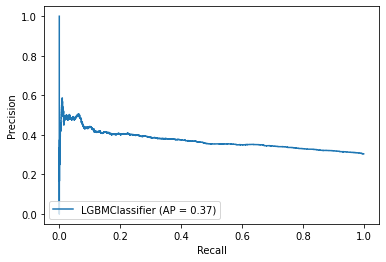

In [101]:
plot_precision_recall_curve(lgbm,X_test,y_test)

## 5) ROC - AUC

- 이진 분류 모델 성능 측정에서 중요하게 사용되는 지표
- auc는 roc 곡선 아래쪽 면적이며 1에 가까울수록 좋은 지표

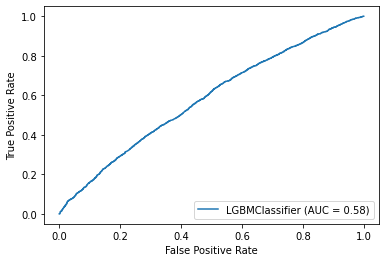

In [99]:
plot_roc_curve(lgbm,X_test,y_test)

In [102]:
roc_auc_score(y_test,lgbm.predict(X_test))

0.5184614329630824

In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
data = encode(data, 'month', 12)

## 회귀 평가지표

### MSE
- 실제 값과 예측값 차 제곱해서 평균

### RMSE
- MSE에 np.sqrt해주면 된다.

### R - Square
- 모델이 데이터를 얼마나 예측하는지에 대한 지표
- 1에 가까울수록 좋은 모델